In [1]:
import os
import re
import sys
import json
import shutil
import argparse

from enum import Enum
from typing import List, Dict

In [448]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import find_peaks
from scipy import integrate

In [420]:
CELSIUS = '°C'

ALPHA = 'α'
BETA = 'β'

In [556]:
R = 8.314  # gas constant

DOYLE_APPROXIMATION_CONSTANT = 1.052

FROM_KILO_COEF = 0.001

In [90]:
# 2D-curve
class Wave:
    def __init__(self):
        self.x = []
        self.y = []
        # self.bl = self._baseline()
    
    def __len__(self):
        assert(len(self.x) == len(self.y))
        return len(self.x)

    # TODO: add size check
    def __sub__(self, other: Wave) -> Wave:
        sub_wave = Wave()
        sub_wave.x = self.x
        sub_wave.y = [item1 - item2 for (item1, item2) in zip(self.y, other.y)]
        return sub_wave

    def add_point(self, x: float, y: float):
        self.x.append(x)
        self.y.append(y)

    def np_x(self) -> np.ndarray:
        return np.array(self.x)

    def np_y(self) -> np.ndarray:
        return np.array(self.y)
    
    # only linear so far
    def baseline(self) -> Wave:
        line = Wave()
        for i, _ in enumerate(self.y):
            new_x = self.x[i]
            new_y = np.interp(new_x, [self.x[0], self.x[-1]], [self.y[0], self.y[-1]])
            line.add_point(new_x, new_y)
        return line

    # def do_subtract_baseline(self):
    #     self -= self.bl

    # TODO: overload operators to work with waves

In [72]:
VERSION_FIELD  = "Version"
SETTINGS_FIELD = "Settings"

# fields in the app_settings.json file
CASE_PATH_FIELD = "PathToArchive"

# fields in the case settings.json file
MATERIAL_FIELD   = "Material"
EXP_TYPE_FIELD   = "ExperimentType"
METHOD_FIELD     = "Method"
CONDITIONS_FIELD = "Conditions"

In [7]:
class Extension(Enum):
    TXT = 1,  # TODO: ".txt"
    ZIP = 2,
    JSON = 3

TXT_EXTENSION  = ".txt"
ZIP_EXTENSION  = ".zip"
JSON_EXTENSION = ".json"

OUTPUT_FOLDER = "Output"

CASE_SETTINGS_FILENAME = "settings"
CASE_SETTINGS_FILE     = CASE_SETTINGS_FILENAME + JSON_EXTENSION

APP_SETTINGS_FILENAME = "app_settings"
APP_SETTINGS_FILE     = APP_SETTINGS_FILENAME + JSON_EXTENSION

In [8]:
class X(Enum):
    TEMPERATURE = 1,  # TODO: "Temperature"
    TIME = 2

class Y(Enum):
    HEAT_FLOW = 1,
    MASS = 2,
    OPT_DENSITY = 3

class ExpType(Enum):
    ISOTHERMAL = 1,
    HEATING = 2,
    COOLING = 3,
    INVALID = 4

class Method(Enum):
    DSC = 1,    # differential scanning calorimetry
    TGA = 2,    # thermogravimetry
    FSC = 3,    # fast scanning calorimetry on a chip, or nanocalorimetry
    POM = 4,    # polarized optical microscopy
    INVALID = 5

In [9]:
class ExperimentData:
    def __init__(self):
        pass

class CaseParams:
    def __init__(self, material: str, 
                 exp_type: ExpType, 
                 method: Method, 
                 file_to_cond_map: Dict[str, float]):
        self.material = material
        self.exp_type = exp_type
        self.method = method
        self.file_to_cond_map = file_to_cond_map

class CaseData:
    def __init__(self, path: str,
                 params: CaseParams, 
                 waves: Dict[float, Wave]):
        self.path = path
        self.params = params
        self.waves = waves

In [10]:
# parse file with experiment data
class WaveReader:
    def __init__(self, path: str):
        self.file_path = path
    
    def read(self) -> Wave:
        wave = Wave()
        # np.loadtxt(self.file_path, ndmin=2)
        with open(self.file_path, 'r', encoding='UTF-8') as file:
            for line in file:
                try:
                    line = line.replace(',', '.')[:-1]  # remove '\n' from the end
                    x, y = re.split(' |\t', line)
                    # print("x = {} -> y = {}".format(x, y), end='')
                    wave.add_point(float(x), float(y))
                except BaseException as e:
                    print("\"{}\" -> {}".format(line, e))
        return wave

In [11]:
class CaseParamsParser:
    def __init__(self, path: str):
        with open(path) as f:
            json_params = json.load(f)
            if SETTINGS_FIELD not in json_params:
                raise ValueError("No " + SETTINGS_FIELD + " field in the settings file")
            elif (json_params := json_params[SETTINGS_FIELD]) and isinstance(json_params, dict):  # TODO: check isinstance
                raise ValueError(SETTINGS_FIELD + " : is not an array")
            else:
                self.json = json_params
                # print(self.json)

    def parse(self) -> CaseParams:
        material = ""
        exp_type = ExpType.INVALID
        method = Method.INVALID
        file_to_cond_map = dict()
        
        # TODO: make this parsing simpler
        for item in self.json:
            if item["name"] == MATERIAL_FIELD:
                material = item["value"]
            elif item["name"] == EXP_TYPE_FIELD:
                if item["value"] == "isothermal":
                    exp_type = ExpType.ISOTHERMAL
                elif item["value"] == "heating":
                    exp_type = ExpType.HEATING
                elif item["value"] == "cooling":
                    exp_type = ExpType.COOLING
                else:
                    raise ValueError("Invalid experiment type found")
            elif item["name"] == METHOD_FIELD:
                if item["value"] == "DSC":
                    method = Method.DSC
                elif item["value"] == "TGA":
                    method = Method.TGA
                elif item["value"] == "FSC":
                    method = Method.FSC
                elif item["value"] == "POM":
                    method = Method.POM
                else:
                    raise ValueError("Invalid method type found")
            elif item["name"] == CONDITIONS_FIELD:
                # value = rate or temperature
                for file, value in item["value"].items():
                    # TODO: do extra check of values
                    file_to_cond_map[file] = float(value)

        return CaseParams(material, exp_type, method, file_to_cond_map)

In [12]:
class ZipUnpacker:
    def __init__(self, path: str):
        if not os.path.exists(path) or os.path.splitext(path)[-1] != ZIP_EXTENSION:
            raise ValueError("Incorrect path to the case archive")
        self.archive_path = path

    def unzip(self) -> str:
        archive_path, archive_name = os.path.split(self.archive_path)
        folder_name = os.path.splitext(archive_name)[0]
        shutil.unpack_archive(self.archive_path, archive_path)
        folder_path = os.path.join(archive_path, folder_name)
        return folder_path

In [13]:
class CaseLoader:
    def __init__(self, path: str):
        self.archive_path = path

    def load(self) -> CaseData:
        folder_path = ZipUnpacker(self.archive_path).unzip()

        settings_path = os.path.join(folder_path, CASE_SETTINGS_FILE)
        case_params = CaseParamsParser(settings_path).parse()

        waves = dict()
        for file, value in case_params.file_to_cond_map.items():
            file_path = os.path.join(folder_path, file)
            waves[value] = WaveReader(file_path).read()

        return CaseData(folder_path, case_params, waves)

In [104]:
class Plotter:
    def __init__(self):
        pass

In [15]:
class KineticsData:
    def __init__(self):
        pass

In [211]:
# initial wave
# conversion wave
# experiment conditions
class ResultDscData:
    def __init__(self):
        self.peak_wave = Wave()  # peak with subtracted baseline
        self.conv_wave = Wave()  # normalized kinetics curve
        self.temperatures = []  # temperature values for approximated lines

In [595]:
class IsoConvMethod:
    def __init__(self):
        ...

In [577]:
# archive_path = './input/ABPOT/TestData.zip'
archive_path = './input/ABPOT/OnlyPeakTestData.zip'

def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('archive_path', type=str)
#     args = parser.parse_args()
#     args.archive_path = archive_path

    try:
        case_data = CaseLoader(archive_path).load()

        # mpl.rcParams['font.sans-serif'] = "Comic Sans MS"
        # mpl.rcParams['font.family'] = "sans-serif"
        plt.figure(figsize=(7, 5), dpi=100)
        # plt.legend()  # TODO: use conditions
        # plt.title("Ozawa-Flynn-Wall Analysis", fontsize=14)
        # plt.title("Kissinger-Akahira-Sunose Analysis", fontsize=14)
        plt.title("Friedman Analysis", fontsize=14)

        # plt.title('DSC: {}'.format(case_data.params.material), fontsize=16)
        # plt.xlabel('Temperature, K', fontsize=14)
        # plt.ylabel('Heat Flow, mW', fontsize=14)
        plt.xlabel('T⁻¹, K⁻¹', fontsize=14)
        # plt.ylabel('ln({})'.format(BETA), fontsize=14)  # OFW
        # plt.ylabel('ln({}/$T^2$)'.format(BETA), fontsize=14)  # KAS
        plt.ylabel('ln(d{}/dt)'.format(ALPHA), fontsize=14)  # Friedman
        
        # plt.xlabel('Conversion', fontsize=14)
        # plt.ylabel('Activation Energy, kJ', fontsize=14)
        
        plt.xlim([-0.05, 1.05])
        plt.ylim([62.5, 107.5])        
        plt.grid()
        
        step = 5  # min 1. TODO: move to settings
        
        conversions = [(conv / 100.) for conv in range(step, 100 - step + 1, step)]
        conversions_count = len(conversions)

        results_dict: Dict[float, ResultDscData] = {}

        for rate, peak_wave in case_data.waves.items():
            peak_wave_upd = peak_wave - peak_wave.baseline()
            x = peak_wave_upd.np_x()
            y = peak_wave_upd.np_y()
            # plt.plot(x, y, '-', label='{}'.format(rate))
            # peaks, properties = find_peaks(y, distance=5000)
            # plt.plot(x[peaks], y[peaks], 'x', )
            
            result_data = ResultDscData()
            result_data.peak_wave = peak_wave_upd

            conv_wave = Wave()
            conv_wave.x = x
            conv_wave.y = np.cumsum(y)
            conv_wave.y /= max(conv_wave.y)
            # plt.plot(conv_wave.x, conv_wave.y, '-', label='{}'.format(rate))
            result_data.conv_wave = conv_wave

            temperatures = []
            conv_id = 0
            for i in range(len(peak_wave_upd)):
                conversion = conversions[conv_id]
                if conv_wave.y[i - 1] < conversion and conv_wave.y[i] > conversion:
                    temperatures.append(conv_wave.x[i])
                    conv_id += 1
                if conv_id == conversions_count:
                    break
            result_data.temperatures = np.array(temperatures)
            # print(temperatures)
            results_dict[rate] = result_data
        
        colors = plt.cm.rainbow(np.linspace(0, 1, conversions_count))

        Ea_wave = Wave()
        for i in range(conversions_count):
            x = []
            y = []
            for rate, dsc_data in results_dict.items():
                inv_temp = 1. / dsc_data.temperatures[i]
                x.append(inv_temp)
                # y.append(np.log(rate / 60.))  # OFW
                # y.append(np.log(rate / 60. * inv_temp**2))  # KAS
                y.append()  # Friedman
            
            # plt.plot(x, y, c=colors[i], marker='*', ms = 8, linestyle='', label='{}'.format(rate))
            coefs = np.polyfit(x, y, 1)
            fit_line_y = np.polyval(coefs, x)
            plt.plot(x, fit_line_y, c=colors[i], linestyle='-', lw=1, label='{}'.format(rate))
            # Ea = -coefs[0] * R / DOYLE_APPROXIMATION_CONSTANT * FROM_KILO_COEF  # OFW
            # Ea = -coefs[0] * R * FROM_KILO_COEF  # KAS
            # Ea_wave.x.append(conversions[i])
            # Ea_wave.y.append(Ea)
        # plt.plot(Ea_wave.x, Ea_wave.y, color='b', marker='o', ms=8, label='{}'.format(rate))

        plt.show()
    except BaseException as e:
        print("Bad case: {}".format(e))

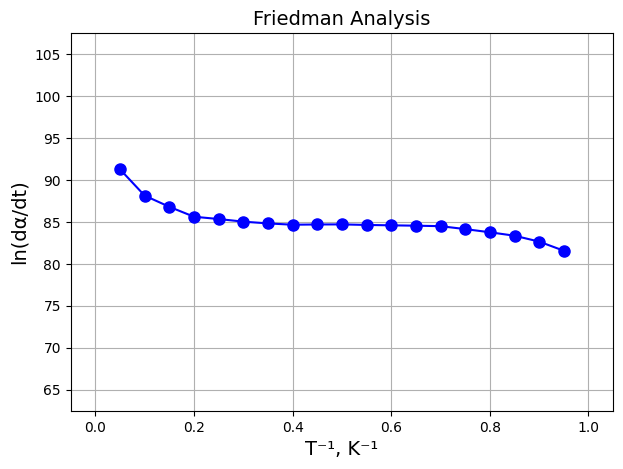

In [578]:
main()

In [593]:
%%latex



$$\frac{dα}{dt} = A(α)f(α)exp(\frac{-E(α)}{RT})$$

<IPython.core.display.Latex object>

In [289]:
# add "normalized" as a parameter
# provide with legends
# !!! provide maybe 500 points for each initial curve
# transform rate "per min" to rate "per sec"
# move "step" in settings

In [ ]:
# https://lingojam.com/SuperscriptGenerator